In [52]:
from typing import List

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, roc_curve
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

##### 1. Wczytanie danych

In [2]:
df: pd.DataFrame = pd.read_csv(
    'breast-cancer.data', sep=',',
    names=['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
)

print(f"Data shape: {df.shape}")
df.head()

Data shape: (286, 10)


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


##### 1.1 Opis danych

1. **Class**: no-recurrence-events, recurrence-events
2. **age**: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
3. **menopause**: lt40, ge40, premeno.
4. **tumor-size**: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
5. **inv-nodes**: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
6. **node-caps**: yes, no.
7. **deg-malig**: 1, 2, 3.
8. **breas**t: left, right.
9. **breast-quad**: left-up, left-low, right-up, right-low, central.
10. **irradia**t: yes, no.

In [3]:
df.dtypes

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

In [4]:
df.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


* Nie ma brakujących danych

In [5]:
df.isna().any()

Class          False
age            False
menopause      False
tumor-size     False
inv-nodes      False
node-caps      False
deg-malig      False
breast         False
breast-quad    False
irradiat       False
dtype: bool

no-recurrence-events:  201
recurrence-events t:  85


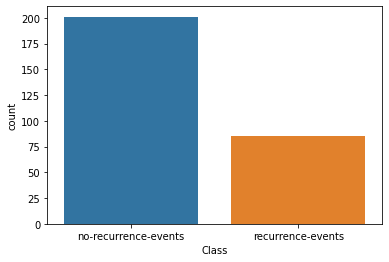

In [6]:
ax = sns.countplot(df['Class'], label="Count")

A, B = df['Class'].value_counts()
print('no-recurrence-events: ', A)
print('recurrence-events t: ', B)

#### 2. Przetwarzanie i wizualizacja danych

##### 2.1 Konwersja do danych liczbowych 

Konwersja `Class` do wartości `0` i `1`

In [7]:
df['Class'] = pd.Categorical(df['Class']).codes

Postaramy się zamienić kolumny `age`, `tumor-size` oraz `inv-nodes` na dane liczbowe uśredniając dostępne przedziały:

In [8]:
def map_parameter(param: str) -> float:
    params = param.split('-')
    a, b = [int(param) for param in params]
    return (a + b) / 2

In [9]:
df['age'] = df['age'].apply(map_parameter)
df['tumor-size'] = df['tumor-size'].apply(map_parameter)
df['inv-nodes'] = df['inv-nodes'].apply(map_parameter)

Pozostałe kolumny nienumeryczne zakodujemy metodą - `One Hot Encoding`:

In [10]:
df_numeric = pd.get_dummies(df, columns=df.select_dtypes(['object']).columns)
df_numeric.head()

,Class,age,tumor-size,inv-nodes,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,...,breast_left,breast_right,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
0,0,34.5,32.0,1.0,3,0,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0
1,0,44.5,22.0,1.0,2,0,0,1,0,1,...,0,1,0,0,0,0,0,1,1,0
2,0,44.5,22.0,1.0,2,0,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0
3,0,64.5,17.0,1.0,2,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,44.5,2.0,1.0,2,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0


In [11]:
df_numeric.describe()

,Class,age,tumor-size,inv-nodes,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,...,breast_left,breast_right,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,...,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,0.297203,51.143357,26.405594,2.573427,2.048951,0.451049,0.024476,0.524476,0.027972,0.776224,...,0.531469,0.468531,0.003497,0.073427,0.384615,0.339161,0.083916,0.115385,0.762238,0.237762
std,0.457828,10.118183,10.529649,3.451904,0.738217,0.498470,0.154791,0.500276,0.165182,0.417504,...,0.499883,0.499883,0.059131,0.261293,0.487357,0.474254,0.277748,0.320046,0.426459,0.426459
min,0.000000,24.500000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,44.500000,22.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,54.500000,27.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,54.500000,32.000000,4.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,74.500000,52.000000,25.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2.2 Wizualizacja danych

Korelacje:

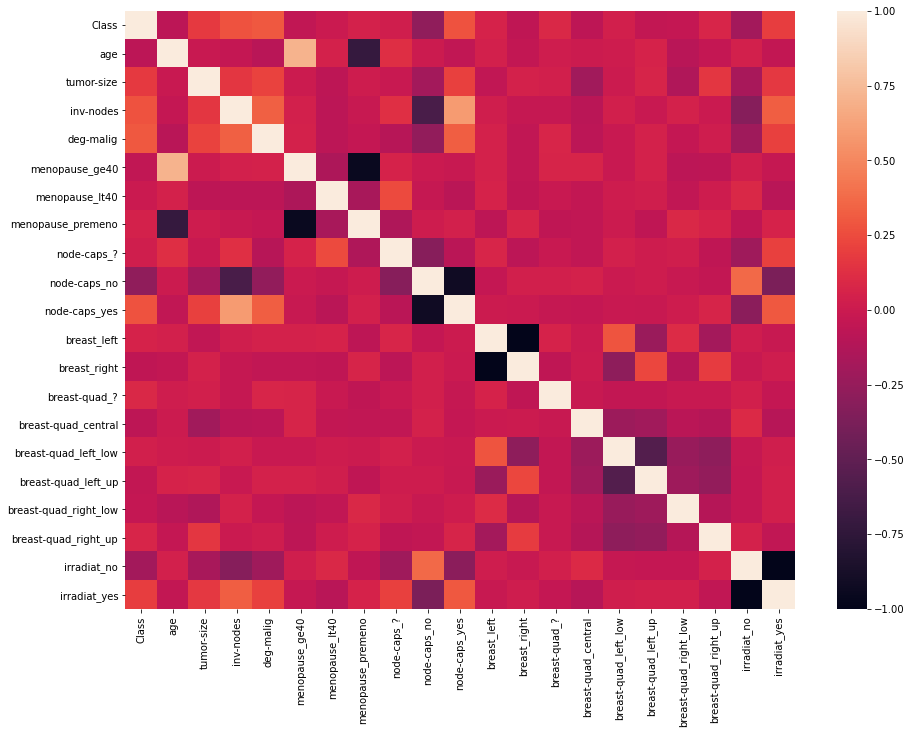

In [12]:
corr = df_numeric.corr()

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corr)
plt.show()

##### 2.3 Przygotowanie danych do uczenia

In [20]:
y = df_numeric['Class']
X = df_numeric.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421, shuffle=True)

### 3. Model - regresja logistyczna

Użyjemy modelu regresji logistycznej - na początek wersja bazowa, dla całego zbioru danych uczących, bez żadnej selekcji cech oraz z domyślnymi parametrami modelu.

In [48]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6724137931034483

In [78]:
from typing import List, Tuple
from numbers import Number


def evaluate_clf(model, K: int = 10, metric: str = 'accuracy', verbose: bool = False, *args, **kwargs) -> Tuple[np.ndarray, np.float]:
    kf = KFold(n_splits=K, shuffle=True)
    scores: List[Number] = []
    
    for k, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = model(*args, **kwargs)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = metrics.accuracy_score(y_test, y_pred)
        scores.append(score)
        if verbose:
            print(f'[{k}] score: {score}')
    
    scores: np.ndarray[Number] = np.array(scores)
    avg = scores.mean()
    
    if verbose:
        plt.figure(figsize=(10, 5))
        ax = sns.lineplot(data=scores, marker='o', color='#965786')
        max_score = scores.max()

        ax.set_title(f'Scores: {metric}, clf: {clf.__class__.__name__}, avg: {avg:.2f}, max: {max_score:.2f}')
        ax.set(xlabel=f'{K}-cross validation', ylabel=f'{metric}')
        plt.show()
    
    return scores, avg

[0] score: 0.7241379310344828
[1] score: 0.6551724137931034
[2] score: 0.7931034482758621
[3] score: 0.7586206896551724
[4] score: 0.5862068965517241
[5] score: 0.6206896551724138
[6] score: 0.6428571428571429
[7] score: 0.75
[8] score: 0.6785714285714286
[9] score: 0.7142857142857143


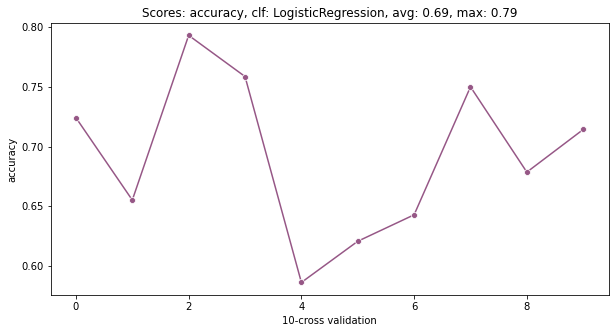

(array([0.72413793, 0.65517241, 0.79310345, 0.75862069, 0.5862069 ,
        0.62068966, 0.64285714, 0.75      , 0.67857143, 0.71428571]),
 0.6923645320197045)

In [79]:
evaluate_clf(linear_model.LogisticRegression, verbose=True)

##### 3.1 Szukanie optymalnych parametrów dla wszystkich danych - na bazie metryki czułości

Wrażliwość / czułość - (wskaźnik prawdziwie pozytywnych wyników) mierzy odsetek pozytywnych wyników, które są prawidłowo zidentyfikowane (tj. Odsetek osób z jakimś stanem (dotkniętym chorobą), które zostały prawidłowo zidentyfikowane jako osoby z daną chorobą).

https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Sensitivity

In [80]:
def get_sensitivity(y_true, y_pred) -> np.float:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

In [81]:
best_sens = 0

for C in np.logspace(-4, 4, 10):
    for penalty in ('l1', 'l2', 'none'):
        solver = 'lbfgs' if penalty in ['l2', 'none'] else 'saga' 
        
        clf = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver)
        if penalty == 'l1':
            for l1_ratio in np.linspace(0, 1, 10):
                clf = linear_model.LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver)

        clf.fit(X_train, y_train)        
        y_pred = clf.predict(X_test)
        
        sensivivity = get_sensitivity(y_test, y_pred)

        if sensivivity > best_sens:
            best_clf = clf
            best_sens = sensivivity
        
        print(f"{clf.__class__.__name__} [C={C}, penalty={penalty}] -> {sensivivity}")
print(f"Najwyższa czułość wyniosła: {best_sens}")

LogisticRegression [C=0.0001, penalty=l1] -> 0.0
LogisticRegression [C=0.0001, penalty=l2] -> 0.0
LogisticRegression [C=0.0001, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.000774263682681127, penalty=l1] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=l2] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.005994842503189409, penalty=l1] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=l2] -> 0.10526315789473684
LogisticRegression [C=0.005994842503189409, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.046415888336127774, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=l2] -> 0.21052631578947367
LogisticRegression [C=0.046415888336127774, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.3593813663804626, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalty=l2] -> 0.15789473684210525
LogisticRegr

In [82]:
best_clf

LogisticRegression(C=0.0001, penalty='none')

[0] score: 0.8275862068965517
[1] score: 0.5862068965517241
[2] score: 0.7586206896551724
[3] score: 0.6896551724137931
[4] score: 0.6896551724137931
[5] score: 0.6206896551724138
[6] score: 0.5357142857142857
[7] score: 0.7857142857142857
[8] score: 0.6428571428571429
[9] score: 0.7857142857142857


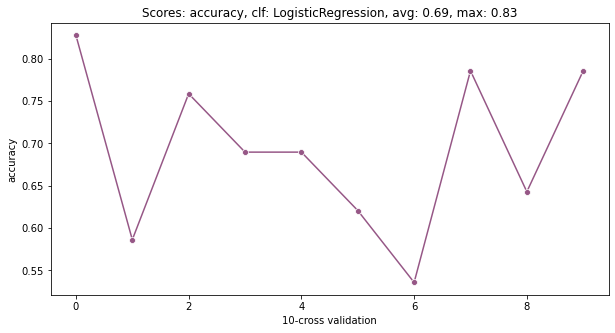

(array([0.82758621, 0.5862069 , 0.75862069, 0.68965517, 0.68965517,
        0.62068966, 0.53571429, 0.78571429, 0.64285714, 0.78571429]),
 0.6922413793103448)

In [83]:
evaluate_clf(linear_model.LogisticRegression, verbose=True, C=0.0001, penalty='none')

##### 3.2 Macierz pomyłek dla najlepszego znalezionego klasyfikatora

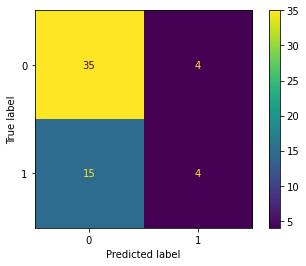

In [84]:
plot_confusion_matrix(best_clf, X_test, y_test)
plt.show()

### 4. Zbadanie wpływu normalizacji, standaryzacji i PCA

#### 4.1 Normalizacja

In [87]:
from sklearn import preprocessing

normalizer  = preprocessing.Normalizer()

X_norm_train = normalizer.fit_transform(X_train)
X_norm_test = normalizer.fit_transform(X_test)

X_norm_train = pd.DataFrame(X_norm_train)
X_norm_test = pd.DataFrame(X_norm_test)

Szukamy teraz klasyfikatora dla znormalizowanych danych

In [88]:
best_sens = 0

for C in np.logspace(-4, 4, 10):
    for penalty in ('l1', 'l2', 'none'):
        solver = 'lbfgs' if penalty in ['l2', 'none'] else 'saga' 
        
        clf = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver)
        if penalty == 'l1':
            for l1_ratio in np.linspace(0, 1, 10):
                clf = linear_model.LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver)

        clf.fit(X_norm_train, y_train)        
        y_pred = clf.predict(X_norm_test)
        
        sensivivity = get_sensitivity(y_test, y_pred)

        if sensivivity > best_sens:
            best_clf = clf
            best_sens = sensivivity
        
        print(f"{clf.__class__.__name__} [C={C}, penalty={penalty}] -> {sensivivity}")
print(f"Najwyższa czułość wyniosła: {best_sens}")

LogisticRegression [C=0.0001, penalty=l1] -> 0.0
LogisticRegression [C=0.0001, penalty=l2] -> 0.0
LogisticRegression [C=0.0001, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.000774263682681127, penalty=l1] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=l2] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.005994842503189409, penalty=l1] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=l2] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.046415888336127774, penalty=l1] -> 0.0
LogisticRegression [C=0.046415888336127774, penalty=l2] -> 0.0
LogisticRegression [C=0.046415888336127774, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.3593813663804626, penalty=l1] -> 0.0
LogisticRegression [C=0.3593813663804626, penalty=l2] -> 0.0
LogisticRegression [C=0.3593813663804626, penalty=none] -> 0.21052631578947367
LogisticRegre

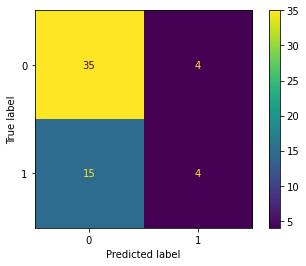

In [89]:
plot_confusion_matrix(best_clf, X_norm_test, y_test)
plt.show()

#### 4.2 Standaryzacja

In [90]:
from sklearn import preprocessing

standard_scaler  = preprocessing.StandardScaler()

X_std_train = standard_scaler.fit_transform(X_train)
X_std_test = standard_scaler.fit_transform(X_test)

X_std_train = pd.DataFrame(X_std_train)
X_std_test = pd.DataFrame(X_std_test)

Szukamy teraz klasyfikatora dla ustandaryzowanych danych

In [91]:
best_sens = 0

for C in np.logspace(-4, 4, 10):
    for penalty in ('l1', 'l2', 'none'):
        solver = 'lbfgs' if penalty in ['l2', 'none'] else 'saga' 
        
        clf = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver)
        if penalty == 'l1':
            for l1_ratio in np.linspace(0, 1, 10):
                clf = linear_model.LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver)

        clf.fit(X_std_train, y_train)        
        y_pred = clf.predict(X_std_test)
        
        sensivivity = get_sensitivity(y_test, y_pred)

        if sensivivity > best_sens:
            best_clf = clf
            best_sens = sensivivity
        
        print(f"{clf.__class__.__name__} [C={C}, penalty={penalty}] -> {sensivivity}")
print(f"Najwyższa czułość wyniosła: {best_sens}")

LogisticRegression [C=0.0001, penalty=l1] -> 0.0
LogisticRegression [C=0.0001, penalty=l2] -> 0.0
LogisticRegression [C=0.0001, penalty=none] -> 0.2631578947368421
LogisticRegression [C=0.000774263682681127, penalty=l1] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=l2] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=none] -> 0.2631578947368421
LogisticRegression [C=0.005994842503189409, penalty=l1] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=l2] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=none] -> 0.2631578947368421
LogisticRegression [C=0.046415888336127774, penalty=l1] -> 0.0
LogisticRegression [C=0.046415888336127774, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=none] -> 0.2631578947368421
LogisticRegression [C=0.3593813663804626, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalt

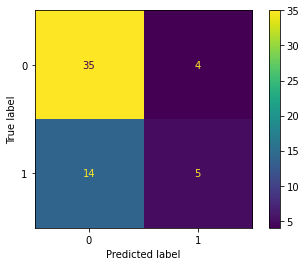

In [92]:
plot_confusion_matrix(best_clf, X_std_test, y_test)
plt.show()

#### 4.3 Analiza głównych składowych - PCA

In [93]:
from sklearn.decomposition import PCA

pca8 = PCA(n_components=8)

X_train_pca = pca8.fit_transform(X_train)
X_test_pca = pca8.fit_transform(X_test)

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

In [94]:
best_sens = 0

for C in np.logspace(-4, 4, 10):
    for penalty in ('l1', 'l2', 'none'):
        solver = 'lbfgs' if penalty in ['l2', 'none'] else 'saga' 
        
        clf = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver)
        if penalty == 'l1':
            for l1_ratio in np.linspace(0, 1, 10):
                clf = linear_model.LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver)

        clf.fit(X_train_pca, y_train)        
        y_pred = clf.predict(X_test_pca)
        
        sensivivity = get_sensitivity(y_test, y_pred)

        if sensivivity > best_sens:
            best_clf = clf
            best_sens = sensivivity
        
        print(f"{clf.__class__.__name__} [C={C}, penalty={penalty}] -> {sensivivity}")
print(f"Najwyższa czułość wyniosła: {best_sens}")

LogisticRegression [C=0.0001, penalty=l1] -> 0.0
LogisticRegression [C=0.0001, penalty=l2] -> 0.0
LogisticRegression [C=0.0001, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.000774263682681127, penalty=l1] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=l2] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.005994842503189409, penalty=l1] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.005994842503189409, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.046415888336127774, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=none] -> 0.21052631578947367
LogisticRegression [C=0.3593813663804626, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalty=l2] -> 0.10526315789473684
LogisticRegr

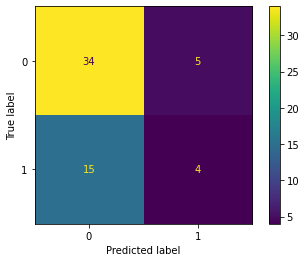

In [95]:
plot_confusion_matrix(best_clf, X_test_pca, y_test)
plt.show()

Dla PCA z 5 głównymi składowymi

In [96]:
pca5 = PCA(n_components=5)

X_train_pca5 = pca5.fit_transform(X_train)
X_test_pca5 = pca5.fit_transform(X_test)

X_train_pca5 = pd.DataFrame(X_train_pca5)
X_test_pca5 = pd.DataFrame(X_test_pca5)

In [97]:
best_sens = 0

for C in np.logspace(-4, 4, 10):
    for penalty in ('l1', 'l2', 'none'):
        solver = 'lbfgs' if penalty in ['l2', 'none'] else 'saga' 
        
        clf = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver)
        if penalty == 'l1':
            for l1_ratio in np.linspace(0, 1, 10):
                clf = linear_model.LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver)

        clf.fit(X_train_pca5, y_train)        
        y_pred = clf.predict(X_test_pca5)
        
        sensivivity = get_sensitivity(y_test, y_pred)

        if sensivivity > best_sens:
            best_clf = clf
            best_sens = sensivivity
        
        print(f"{clf.__class__.__name__} [C={C}, penalty={penalty}] -> {sensivivity}")
print(f"Najwyższa czułość wyniosła: {best_sens}")

LogisticRegression [C=0.0001, penalty=l1] -> 0.0
LogisticRegression [C=0.0001, penalty=l2] -> 0.0
LogisticRegression [C=0.0001, penalty=none] -> 0.15789473684210525
LogisticRegression [C=0.000774263682681127, penalty=l1] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=l2] -> 0.0
LogisticRegression [C=0.000774263682681127, penalty=none] -> 0.15789473684210525
LogisticRegression [C=0.005994842503189409, penalty=l1] -> 0.0
LogisticRegression [C=0.005994842503189409, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.005994842503189409, penalty=none] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=l2] -> 0.15789473684210525
LogisticRegression [C=0.046415888336127774, penalty=none] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalty=l1] -> 0.15789473684210525
LogisticRegression [C=0.3593813663804626, penalty=l2] -> 0.15789473684210525
LogisticRegr

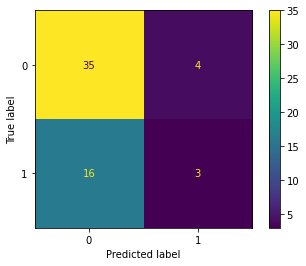

In [98]:
plot_confusion_matrix(best_clf, X_test_pca5, y_test)
plt.show()